# Shape analysis with skeletal models and Principal Nested Spheres

# 1. Introduction and Motivation

This notebook considers anatomical shape anlysis with skeletal representations (s-reps) and Principal Nested Spheres (PNS). 

S-reps can provide rich geometric information of medical objects and good correspondences across cases. A continuous s-rep consists of a skeleton and two functions defined on the skeleton, namely, a radial vector field and a radius function. This notebook showcases the representation power of discrete s-reps, while we provide a python interface to interpolate a discrete s-rep to a continuous one. 

PNS addresses the non-Euclidean properties of shape data in statistical analysis. Unlike other manifold learning methods, PNS fits a hierarchy of submanifolds (i.e., subspheres) to data such that the resulting statistical representation is more robust in High Dimensional Low Sample Size (HDLSS) problems.

The implementation of the above two methods are based on the following references.

> Liu, Z., Hong, J., Vicory, J., Damon, J. N., & Pizer, S. M. (2021). Fitting unbranching skeletal structures to objects. Medical Image Analysis, 70, 102020.

> Kim, Byungwon, Jörn Schulz, and Sungkyu Jung. "Kurtosis test of modality for rotationally symmetric distributions on hyperspheres." Journal of Multivariate Analysis 178 (2020): 104603.

Also, a reader can refer to the following papers for a good review of Non-Euclidean data analysis.
> Schulz, J., Pizer, S. M., Marron, J. S., & Godtliebsen, F. (2016). Non-linear hypothesis testing of geometric object properties of shapes applied to hippocampi. Journal of Mathematical Imaging and Vision, 54(1), 15-34.

> Pizer, S. M., Hong, J., Vicory, J., Liu, Z., Marron, J. S., Choi, H. Y., ... & Wang, J. (2020). Object shape representation via skeletal models (s-reps) and statistical analysis. In Riemannian Geometric Statistics in Medical Image Analysis (pp. 233-271). Academic Press.

### 1.1 Environment
This notebook runs under python 3. To run the notebook, the following packages are needed.

```python
pip install -r requirements.txt 
```

*or*


In [1]:
import sys
!{sys.executable} -m pip install numpy scipy geomstats sklearn vtk nlopt

# 2. Analysis with PNS and s-rep on toy data

In this section, we show how to fit principal nested (sub-)spheres to non-Euclidean data that distribute on $\mathbb{S}^2$. The resulting principal component gives statistically efficient representations of the variation. Then we show the fitting process of s-reps. Finally, we analyze simulated shape data with the s-reps and PNS. 

## 2.1. Toy example of PNS

This section shows a toy example in which non-Euclidean data distributed on $\mathbb{S}^2$ are considered. The results from PNS can faithfully capture the variation patterns with fewer components.

#### Simulate non-Euclidean data
The simulated data is a combination of 
- The major signal that lies on a small circle distribution on $\mathbb{S}^2$.
- Random noise (i.i.d.) sampled from a Gaussian distribution (see the documentation in utils.py).

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import geomstats.visualization as visualization
from principal_nested_spheres import PNS
from utils import *
visualization.tutorial_matplotlib()
import warnings
warnings.filterwarnings('ignore')

INFO: Using numpy backend


<IPython.core.display.Javascript object>


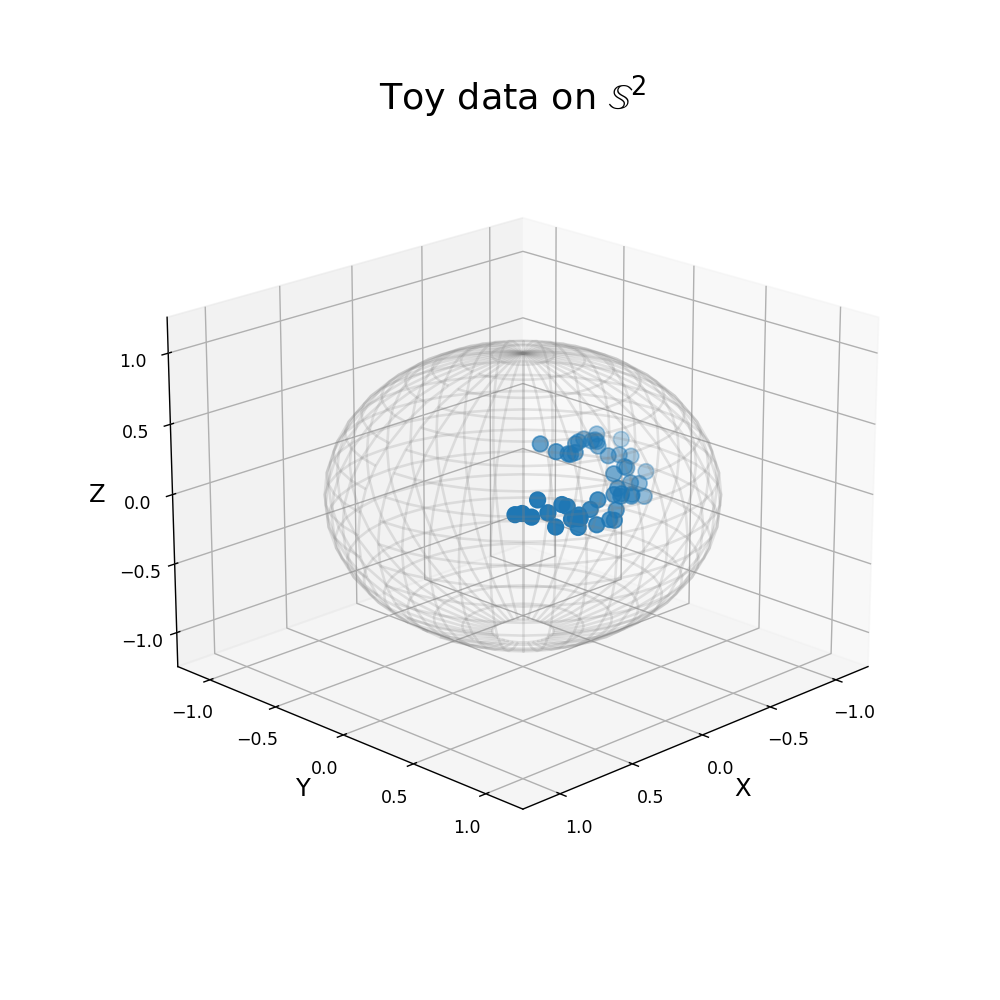

In [17]:
## Generate 50 data points on S^2
data = simulate_data_on_small_circle(50)

%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

ax.set_title('Toy data on $\mathbb{S}^2$')
visualization.plot(
    data.T, ax=ax, space='S2', label='Point', s=80)

ax.view_init(20,45)

#### Fit PNS model to the toy data
We denote the mapping via PNS as $\phi: \mathcal{M}\mapsto \mathbb{R}^d$. The mapping is also referred to as *Euclidenization*. Correspondingly, the pullback is denoted by $\phi^{-1}$. The following cell showcases 
- The Euclideanization with PNS, i.e., $Z=\phi(X)$.
- Pullback from the Euclidean space to the data space with $\hat{X}=\phi^{-1}(Z)$.
- Compare the original data $X$ and pullback result $\hat{X}$. *Invertible* is true if they are identical.

The return value `resmat` can be understood as principal component scores, while `PNS_coords` contains the details of fitted components.

In [18]:
################ Fit PNS to data ################
pns_model = PNS(data, itype=9)
pns_model.fit()
resmat, PNS_coords = pns_model.output
print(data.shape)
print(resmat.shape)

################ Invert the resmat ################
invert_pns = PNS.inv(resmat, PNS_coords)

### The inverse should be the same with the original data
print("Invertible??")
print(np.allclose(np.array(data, dtype=float), np.array(invert_pns, dtype=float)))

Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  SMALL  sphere
(3, 50)
(2, 50)
Invertible??
True


#### Visualize the fitted results
Here, we show the fitted principal subsphere (i.e., $\mathbb{S}^1$) from PNS. The PNS mean lies on this principal subsphere and can be used to represent the population. As a comparison, we also show the moments resulting from *geomstats*, using *FrechetMean* and *TangentPCA*.

<IPython.core.display.Javascript object>


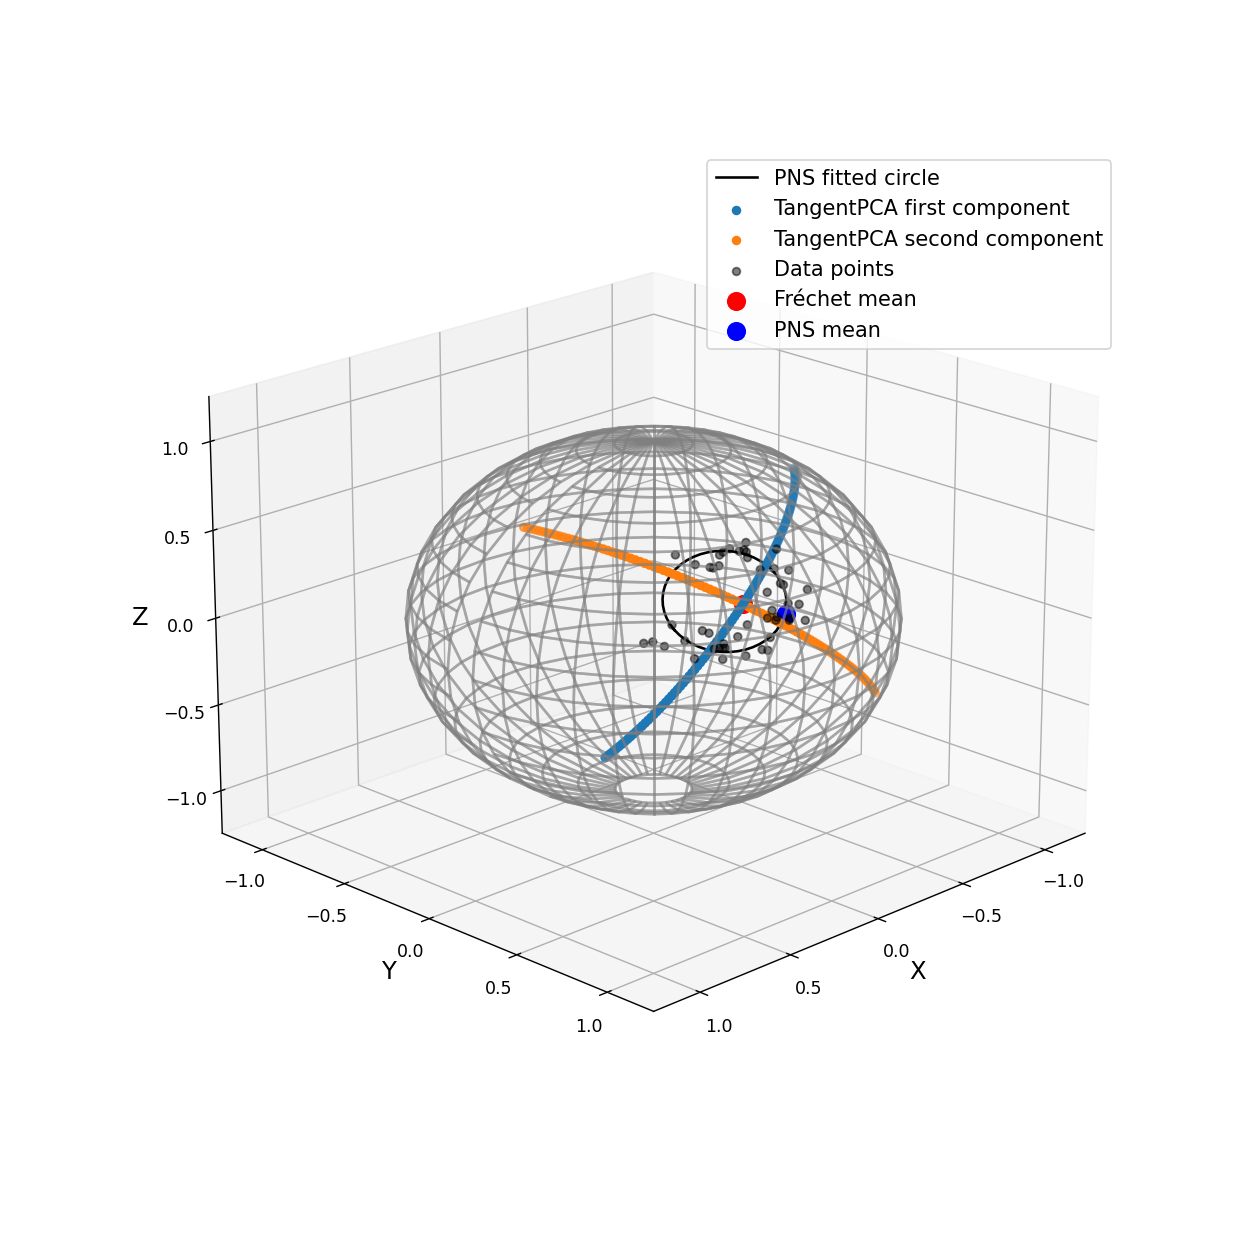

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.pca import TangentPCA
from geomstats.geometry.hypersphere import Hypersphere


sphere = Hypersphere(dim=2)

mean = FrechetMean(metric=sphere.metric)
mean.fit(data.T)

mean_estimate = mean.estimate_
tpca = TangentPCA(metric=sphere.metric, n_components=2)
tpca = tpca.fit(data.T, base_point=mean_estimate)
tangent_projected_data = tpca.transform(data.T)

geodesic_0 = sphere.metric.geodesic(
        initial_point=mean_estimate,
        initial_tangent_vec=tpca.components_[0])
geodesic_1 = sphere.metric.geodesic(
        initial_point=mean_estimate,
        initial_tangent_vec=tpca.components_[1])

n_steps = 100
t = gs.linspace(-1., 1., n_steps)
geodesic_points_0 = geodesic_0(t)
geodesic_points_1 = geodesic_1(t)

#Draw circle on S2
circlePoints = drawCircleS2(center=np.transpose(PNS_coords['orthaxis'][0])[0],theta=PNS_coords['radii'][1])

%matplotlib notebook


fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

ax = visualization.plot(
    geodesic_points_0, ax, space='S2', linewidth=1, label='TangentPCA first component')
ax = visualization.plot(
    geodesic_points_1, ax, space='S2', linewidth=1, label='TangentPCA second component')
# ax = visualization.plot( #small circle
#     circlePoints, ax, space='S2', color='black', linewidth=1 , label='Fitted circle')
ax = visualization.plot(
    data.T, ax, space='S2', color='black', alpha=0.5, label='Data points')
ax = visualization.plot(
    mean_estimate, ax, space='S2', color='red', s=100, label='Fréchet mean')
ax = visualization.plot(
    PNS_coords['mean'].T, ax, space='S2', color='blue', s=100, label='PNS mean')

ax.plot(
    circlePoints[:, 0],
    circlePoints[:, 1],
    circlePoints[:, 2],
    linestyle='-', color='black',alpha=1,label='PNS fitted circle')

ax.legend()
ax.view_init(20,45)

plt.show()

#### Comparison between PNS, Tangent PCA, & PCA
Using the above simulated data, the next graph compares the statistical efficiency of different methods, including PNS, Tangent PCA and PCA. It suggests that PNS captures a significant amount (~98.5%) with one principal component. Considering the unimodal variation pattern of the simulated signals, PNS produces more efficient statistical representations than the compared methods.

<IPython.core.display.Javascript object>


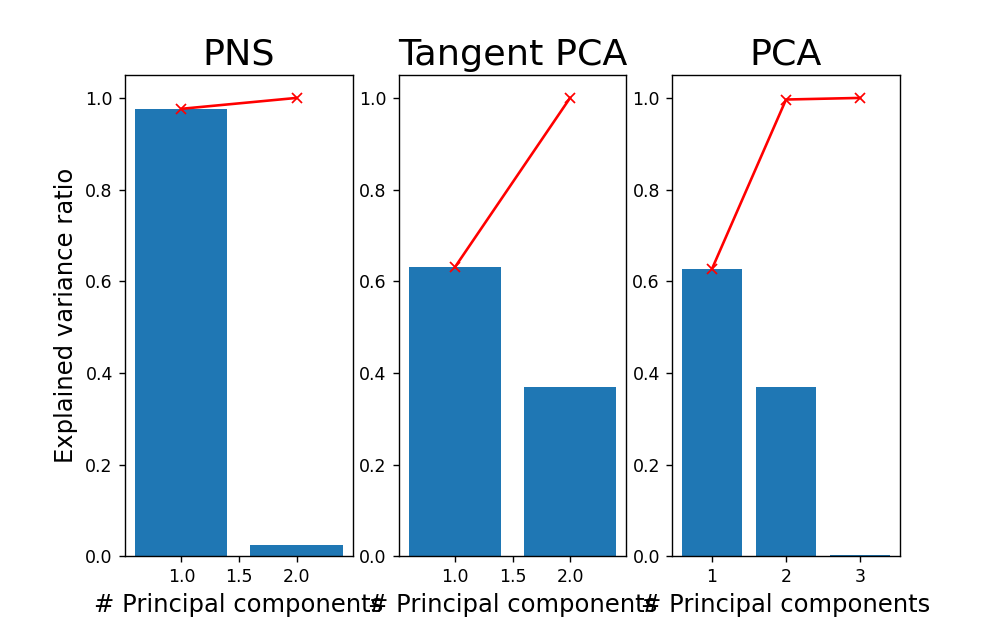

In [20]:
from sklearn.decomposition import PCA
### 1. The Euclidean representation (resmat) from PNS
pns_pca = PCA()
pns_pca.fit(resmat.T)
explained_variance_ratio = pns_pca.explained_variance_ratio_
num_components_pns = len(explained_variance_ratio)
pns_cum_ratio = []
for i in range(1, num_components_pns + 1):
    pns_cum_ratio.append(np.sum(explained_variance_ratio[:i]))

### 2. Tangent PCA
tpca = TangentPCA(metric=sphere.metric, n_components=2)
tpca = tpca.fit(data.T, base_point=mean_estimate)
tangent_projected_data = tpca.transform(data.T)

tpca_explained_ratio = tpca.explained_variance_ratio_
num_components_tpca = len(tpca_explained_ratio)
tpca_cum_ratio = []
for i in range(1, num_components_tpca + 1):
    tpca_cum_ratio.append(np.sum(tpca_explained_ratio[:i]))

### 3. Vanilla PCA
pure_pca = PCA()
pure_pca.fit(data.T)
pca_explained_ratio = pure_pca.explained_variance_ratio_
num_components_pca = len(pca_explained_ratio)
pca_cum_ratio = []
for i in range(1, num_components_pca + 1):
    pca_cum_ratio.append(np.sum(pca_explained_ratio[:i]))

### 4. Show the above results together
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(8, 5)

axs[0].bar(range(1, num_components_pns + 1), explained_variance_ratio)
axs[0].plot(np.arange(1, num_components_pns + 1), pns_cum_ratio, 'r-x')
axs[0].set_title('PNS')
axs[0].set_ylabel('Explained variance ratio')
axs[0].set_xlabel('# Principal components')

axs[1].bar(range(1, num_components_tpca + 1), tpca_explained_ratio)
axs[1].plot(range(1, num_components_tpca + 1), tpca_cum_ratio, 'r-x')
axs[1].set_title('Tangent PCA')
axs[1].set_xlabel('# Principal components')

axs[2].bar(range(1, num_components_pca + 1), pca_explained_ratio)
axs[2].plot(range(1, num_components_pca + 1), pca_cum_ratio, 'r-x')
axs[2].set_title('PCA')
axs[2].set_xlabel('# Principal components')


plt.show()

## 2.2. Fit s-reps to ellipsoids

This section shows how to fit s-reps to simulated 3D shapes. With the prior knowledge of (non-branching) topology of objects, we fit s-reps to object in two stages: (1) we deform the s-rep of an ellipsoid to the object and (2) we optimize the s-reps to have better skeletal properties as described in [(Liu et al)](https://www.sciencedirect.com/science/article/abs/pii/S1361841521000669). Note that for a general non-branching object (e.g., a hippocampus), this method can also result in a good fit.

#### Load surface meshes of objects
Here, the surface of a standard ellipsoid (shown in blue) is used as the template from which we obtain the template s-rep, while `obj_mesh` (shown in grey) is the target object to which we aim to fit an s-rep.

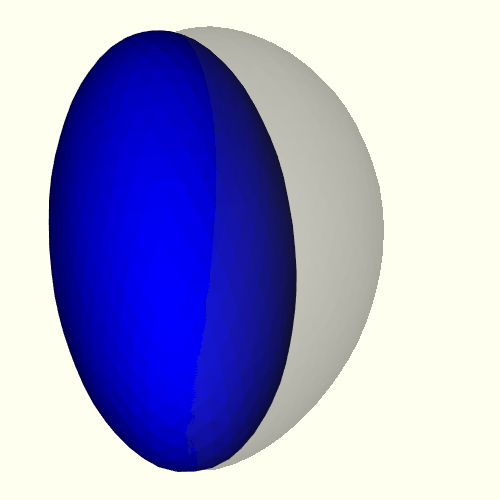

In [7]:
import vtk
import numpy as np
from utils import *


reader = vtk.vtkPolyDataReader()
reader.SetFileName('data/std_ell_label_SPHARM.vtk')
reader.Update()
standard_ellipsoid = reader.GetOutput()

reader2 = vtk.vtkPolyDataReader()
reader2.SetFileName('data/bot0_label_SPHARM.vtk')
reader2.Update()
obj_mesh = reader2.GetOutput()

render = overlay_poly_data(standard_ellipsoid, obj_mesh)
vtk_show(render, 500, 500)

#### Fit an s-rep to the target object
A discrete s-rep consists of a discretized skeleton and spokes pointing from the skeletal points to the boundary. In the following figure, we show both the surface boundary (in grey) and the spokes (in blue) of the srep.

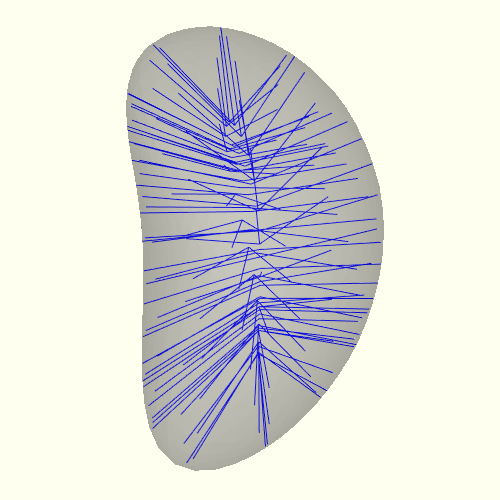

In [8]:
from fit_srep import fit_srep
import nlopt

deformed_srep = fit_srep(obj_mesh, standard_ellipsoid)
%matplotlib inline
render = overlay_poly_data(deformed_srep, obj_mesh)
vtk_show(render, 500, 500)

## 2.3. Classify s-reps with PNS
In this section, we show the classification of simulated shapes with s-reps and PNS. Compared with boundary points, s-reps can provide richer geometric information (e.g., objects' widths and local orientations) such that subtle shape variation can be captured. 

In the following experiments, we simulated two groups of ellipsoids. The control group is a set of standard ellipsoids, while the randomely deformed group is a set of slightly bended ellipsoids. We classify these two groups with (1) features (spokes' directions) from s-reps and (2) boundary points. The results show that the spokes' directions can better capture these subtle deformations of the shapes.

In [9]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics

### 1. Load / simulate data
controlData = []
for i in range(0, 10):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName('data/control/top_srep_twist' + str(i) + '.vtk')
    reader.Update()
    srep = reader.GetOutput()
    controlData.append(srep)

bentData = []
for i in range(0, 10):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName('data/bent/top_srep_twist' + str(i) + '.vtk')
    reader.Update()
    srep = reader.GetOutput()
    bentData.append(srep)
    
num_spokes = controlData[0].GetNumberOfCells()
bentEucData = np.zeros((num_spokes*2, len(bentData) + len(controlData)))
bentBdryPt = np.zeros((num_spokes*3, len(bentData) + len(controlData)))
labs = np.zeros(len(bentData) + len(controlData))
labs[0:10] = np.zeros(10)
labs[10:20] = np.ones(10)
labStr1 = ["control"]*10
labStr2 = ["bent"]*10
labStr1 = labStr1+labStr2

In [10]:
### 2. Euclideanize spoke directions with PNS
for i in range(num_spokes-1):
    bentMat = np.zeros((3, len(bentData) + len(controlData)))
    bentPt = np.zeros((3, len(bentData) + len(controlData)))
    for j in range(0, bentMat.shape[1]):
        if j < len(controlData):
            id_base_pt = i * 2
            id_bdry_pt = id_base_pt + 1
            base_pt = np.array(controlData[j].GetPoint(id_base_pt))
            bdry_pt = np.array(controlData[j].GetPoint(id_bdry_pt))
            radius = np.linalg.norm(bdry_pt - base_pt)
            direction = (bdry_pt - base_pt) / radius

            bentMat[0][j] = direction[0]
            bentMat[1][j] = direction[1]
            bentMat[2][j] = direction[2]
            
            bentPt[0][j] = bdry_pt[0]
            bentPt[1][j] = bdry_pt[1]
            bentPt[2][j] = bdry_pt[2]
        else:
            base_pt = np.array(bentData[j - len(controlData)].GetPoint(id_base_pt))
            bdry_pt = np.array(bentData[j - len(controlData)].GetPoint(id_bdry_pt))
            radius = np.linalg.norm(bdry_pt - base_pt)
            direction = (bdry_pt - base_pt) / radius

            bentMat[0][j] = direction[0]
            bentMat[1][j] = direction[1]
            bentMat[2][j] = direction[2]
            
            bentPt[0][j] = bdry_pt[0]
            bentPt[1][j] = bdry_pt[1]
            bentPt[2][j] = bdry_pt[2]
            
            
    pns_model = PNS(bentMat, itype=9)
    pns_model.fit()
    resmat, PNS_coords = pns_model.output
    bentEucData[i*2:i*2+2, :] = resmat
    bentBdryPt[i*3:i*3+3, :] = bentPt

Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  GREAT  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  GREAT  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  GREAT  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  GREAT  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  SMALL  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  SMALL  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  GREAT  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  SMALL  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  SMALL  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  GREAT  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  SMALL  sphere
Testing with kurtosis

Fit subspheres iteration reached 30th with residuals: 0.01352818186277921
2-sphere to 1-sphere by fitting a  SMALL  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  GREAT  sphere
Testing with kurtosis using alpha: 0.05
Fit subspheres iteration reached 30th with residuals: 0.0009131065011619508
2-sphere to 1-sphere by fitting a  SMALL  sphere
Testing with kurtosis using alpha: 0.05
Fit subspheres iteration reached 30th with residuals: 1.8391699279770787e-05
Fit subspheres iteration reached 30th with residuals: 2.0617468941613523e-05
2-sphere to 1-sphere by fitting a  SMALL  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  GREAT  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  GREAT  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  GREAT  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  GREAT  sphere
Testing with kurtosis us

2-sphere to 1-sphere by fitting a  SMALL  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  SMALL  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  GREAT  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  SMALL  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  SMALL  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  SMALL  sphere
Testing with kurtosis using alpha: 0.05
2-sphere to 1-sphere by fitting a  SMALL  sphere


In [11]:
### 3. Partition data, Train and Test LogisticRegression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
def train_test_one_experiment(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.2, random_state=42)
    clf = LogisticRegression(solver="liblinear", random_state=0).fit(X_train, y_train)
    test_scores = clf.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, test_scores)
    
    return clf.score(X_test, y_test), test_auc
def repeated_experiments(data, labs):
    aucs = []
    scores = []
    num_experiments = 100
    for i in range(num_experiments):
        if i % 20 == 0:
            print("Performing %d th experiment..." % (i+1))
        test_scores, auc = train_test_one_experiment(data, labs)
        aucs.append(auc)
        scores.append(test_scores)

    np_scores = np.array(scores)
    return np.mean(aucs), np.mean(np_scores), np.std(np_scores)
# non-Euclidean data
avg_auc, avg_score, std_score = repeated_experiments(bentBdryPt.T, labs)
# Euclideanized feature
avg_auc_euc, avg_score_euc, std_score_euc = repeated_experiments(bentEucData.T, labs)

print("Non-Euclidean features result in Average accuracy: %0.2f"%(avg_score))
print("Euclideanized features result in Average accuracy: %0.2f"%(avg_score_euc))

Performing 1 th experiment...
Performing 21 th experiment...
Performing 41 th experiment...
Performing 61 th experiment...
Performing 81 th experiment...
Performing 1 th experiment...
Performing 21 th experiment...
Performing 41 th experiment...
Performing 61 th experiment...
Performing 81 th experiment...
Non-Euclidean features result in Average accuracy: 0.50
Euclideanized features result in Average accuracy: 0.75


In [12]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca_result = pca.fit_transform(bentEucData.T)
print('Explained variation per principal component by Euclidean s-rep data: {}'.format(pca.explained_variance_ratio_))

pca = PCA(n_components=2)
pca_result2 = pca.fit_transform(bentBdryPt.T)
print('Explained variation per principal component by Boundary Pts: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component by Euclidean s-rep data: [0.77918417 0.21878946]
Explained variation per principal component by Boundary Pts: [0.6369785  0.34985934]


# 3. Analysis on geomstats datasets

In this part, we utilize PNS residuals to classify hands configurations from geomstats.datasets.utils. We apply supervised SVM and logistic regression.
Also, we do the same classification on landmarks 3D coordinates and the Euclideanized Kendall metrics and compare the results.

#### Read and vectorize data

In [13]:
import geomstats.datasets.utils as data_utils

hands, labels, bone_list = data_utils.load_hands()
n_hands, k_landmarks, dim = hands.shape

# Alignment
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric

preshape = PreShapeSpace(m_ambient=dim, k_landmarks=k_landmarks)
hands_preshape = preshape.projection(hands)
base_point = hands_preshape[0]

hands_shape = preshape.align(point=hands_preshape, base_point=base_point)
print(hands_shape.shape)

hands_flatten = np.reshape(hands, (n_hands, -1))
handsShape_flatten=np.reshape(hands_shape, (n_hands, -1))

print(handsShape_flatten.shape)
print(np.sqrt(np.sum(np.power(handsShape_flatten.T,2),axis=0))) #each column is an observation on the hypersphere

(52, 22, 3)
(52, 66)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


#### Calculate PNS residuals

In [14]:
from principal_nested_spheres import PNS

pns_hands = PNS(handsShape_flatten.T, itype=9)

pns_hands.fit()
resmatHands, PNS_coordsHands = pns_hands.output
print("Done!")
print(labels.shape)
print(resmatHands.T.shape)

Testing with kurtosis using alpha: 0.05
51-sphere to 50-sphere by fitting a  SMALL  sphere
50-sphere to 49-sphere by fitting a  GREAT  sphere
49-sphere to 48-sphere by fitting a  GREAT  sphere
48-sphere to 47-sphere by fitting a  SMALL  sphere
47-sphere to 46-sphere by fitting a  GREAT  sphere
46-sphere to 45-sphere by fitting a  SMALL  sphere
45-sphere to 44-sphere by fitting a  GREAT  sphere
44-sphere to 43-sphere by fitting a  SMALL  sphere
43-sphere to 42-sphere by fitting a  GREAT  sphere
42-sphere to 41-sphere by fitting a  SMALL  sphere
41-sphere to 40-sphere by fitting a  GREAT  sphere
40-sphere to 39-sphere by fitting a  GREAT  sphere
39-sphere to 38-sphere by fitting a  SMALL  sphere
38-sphere to 37-sphere by fitting a  GREAT  sphere
37-sphere to 36-sphere by fitting a  SMALL  sphere
36-sphere to 35-sphere by fitting a  GREAT  sphere
35-sphere to 34-sphere by fitting a  GREAT  sphere
34-sphere to 33-sphere by fitting a  GREAT  sphere
Fit subspheres iteration reached 30th with

#### Classification

In [15]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from geomstats.geometry.euclidean import EuclideanMetric

###########################################################################################################
###########################################################################################################
# classification by hands 3D landmark data 
hands_flatten = np.reshape(hands, (n_hands, -1)) # hands_flatten is matrix and each row is a sample 
X = hands_flatten
y = labels

#cross validation LogisticRegression
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
logreg = LogisticRegression()
scores = cross_val_score(logreg, X, y, cv=cv)
logreg_accuracy = scores.mean()
print("Logistic regression has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

#cross validation SVM
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=cv)
SVM_accuracy = scores.mean()
print("SVM has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

result_3Dcoordinates = {"data": "3D coordinates", "Logistic regression":logreg_accuracy, "SVM":SVM_accuracy }

###########################################################################################################
###########################################################################################################
#classification by kendall_metric
kendall_metric = KendallShapeMetric(m_ambient=dim, k_landmarks=k_landmarks)
kendall_pair_dist = kendall_metric.dist_pairwise(hands_shape)
kendall_pair_dist

X = kendall_pair_dist
y = labels

#cross validation LogisticRegression
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
logreg = LogisticRegression()
scores = cross_val_score(logreg, X, y, cv=cv)
logreg_accuracy = scores.mean()
print("Logistic regression has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

#cross validation SVM
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=cv)
SVM_accuracy = scores.mean()
print("SVM has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

result_kendall_metric = {"data": "Kendall metric", "Logistic regression":logreg_accuracy, "SVM":SVM_accuracy }

###########################################################################################################
###########################################################################################################
#classification by PNS residuals
X = resmatHands.T
y = labels

#cross validation LogisticRegression
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
logreg = LogisticRegression()
scores = cross_val_score(logreg, X, y, cv=cv)
logreg_accuracy = scores.mean()
print("Logistic regression has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

#cross validation SVM
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=cv)
SVM_accuracy = scores.mean()
print("SVM has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

result_PNS_residuals = {"data": "PNS residuals", "Logistic regression":logreg_accuracy, "SVM":SVM_accuracy }
###########################################################################################################
###########################################################################################################
#classification by SVM on Euclidean Metric of PNS residuals

eucl_metric = EuclideanMetric(resmatHands.T.shape[1])  
eucl_pair_dist = eucl_metric.dist_pairwise(resmatHands.T) #calculate distance between each pair
X = eucl_pair_dist
y = labels

#cross validation LogisticRegression
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
logreg = LogisticRegression()
scores = cross_val_score(logreg, X, y, cv=cv)
logreg_accuracy = scores.mean()
print("Logistic regression has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

#cross validation SVM
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=cv)
SVM_accuracy = scores.mean()
print("SVM on Euclidean metric has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

result_PNS_residuals_EuclideanMetric = {"data": "PNS residuals Euclidean metric", "Logistic regression":logreg_accuracy, "SVM":SVM_accuracy }


Logistic regression has 0.53 accuracy with a standard deviation of 0.14
SVM has 0.49 accuracy with a standard deviation of 0.12
Logistic regression has 0.73 accuracy with a standard deviation of 0.09
SVM has 0.74 accuracy with a standard deviation of 0.09
Logistic regression has 0.67 accuracy with a standard deviation of 0.10
SVM has 0.72 accuracy with a standard deviation of 0.11
Logistic regression has 0.73 accuracy with a standard deviation of 0.09
SVM on Euclidean metric has 0.72 accuracy with a standard deviation of 0.10


#### Results

In [16]:
import pandas as pd
results = pd.DataFrame([result_3Dcoordinates,result_kendall_metric,
                        result_PNS_residuals, result_PNS_residuals_EuclideanMetric])
results

,data,Logistic regression,SVM
0,3D coordinates,0.53125,0.49375
1,Kendall metric,0.73125,0.73750
2,PNS residuals,0.66875,0.72500
3,PNS residuals Euclidean metric,0.73125,0.71875


We used 3D coordinates of the landmarks, PNS residuals, and Kendall metric for the classification. Classifications based on Euclideanized data (i.e., PNS residuals and Kendall metric) have a better performance compared with the 3D coordinates. However, in this case, the PNS residual has no superiority over the Kendall metric. A possible explanation could be that we have concentrated or normally distributed data on the hypersphere, i.e., we may not have girdle distributions.

# 4. Limitations and Perspectives

We presented, in this notebook, a statistical and a geometric model for shape analysis. We showed how to **fit** non-branching s-reps to (non-branching) objects. The geometric model (i.e., s-reps) gives topologically consistent skeletal representations. Such consistency is favorable in statistical analysis, especially in the tasks (e.g., medical image analysis) where noise is non-negligible. Moreover, we showed how to analyze s-reps with PNS for 3D shapes. The analysis yields more effective statistical representation such that subtle shape variations can be well captured.

In addition, there exist several directions to improve this python interface. First, we will provide more visualization tools to illustrate the goodness of fit of principal nested spheres. Second, the input types is limited to triangle meshes in the current implementation of the s-reps fitting algorithm. In the future, we will add interfaces to deal with input of other formats (e.g., label maps).  Third, this python interface simplified the fitting process of s-reps from the method due to Liu et al. To better represent the boundary geometry, we will add normality and skeletal regularity into the objective of the refinement. For a full implementation of the s-rep fitting, a user can refer to [SlicerSALT](http://salt.slicer.org/). Fourth, we intend to reimplement the current algorithms with pytorch and other deep learning framework.